In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data import stock_data
from wfwGARCH import clusteringTest, GARCHWalkForward
from hvPred import HVmodel

In [17]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [18]:
finance = [
    "JPM",  # JPMorgan Chase
    "BAC",  # Bank of America
    "C",    # Citigroup
    "GS",   # Goldman Sachs
    "MS",   # Morgan Stanley
    "AXP",  # American Express
    "WFC",  # Wells Fargo
    "USB",  # U.S. Bancorp
    "PNC",  # PNC Financial Services
    "SCHW"  # Charles Schwab
]

tech = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "NVDA",  # Nvidia
    "GOOGL", # Alphabet (Google)
    "AMD",   # Advanced Micro Devices
    "INTC",  # Intel
    "TSLA",  # Tesla (tech-adjacent)
    "CRM",   # Salesforce
    "ORCL",  # Oracle
    "AVGO"   # Broadcom
]

etf = [
    "SPY",   # S&P 500 ETF
    "QQQ",   # Nasdaq 100 ETF
    "IWM",   # Russell 2000 ETF
    "VXX",   # Volatility ETF
    "XLK",   # Technology Sector ETF
    "XLF",   # Financial Sector ETF
    "ARKK",  # ARK Innovation ETF
    "DIA",   # Dow Jones ETF
    "EEM",   # Emerging Markets ETF
    "TLT"    # 20+ Year Treasury Bond ETF
]

health_tech = [
    "MRNA",  # Moderna Inc.
    "BIIB",  # Biogen Inc.
    "VRTX",  # Vertex Pharmaceuticals
    "REGN",  # Regeneron Pharmaceuticals
    "ILMN",  # Illumina Inc.
    "DXCM",  # Dexcom Inc.
    "CRSP",  # CRISPR Therapeutics (mid-cap but very volatile)
    "NVCR"   # NovoCure Ltd. (mid-cap, high volatility)
]

commodity = [
    # Energy
    "XOM",  # Exxon Mobil
    "CVX",  # Chevron
    "SLB",  # Schlumberger

    # Metals & Mining
    "NEM",  # Newmont Corporation (Gold)
    "GOLD", # Barrick Gold
    "FCX",  # Freeport-McMoRan (Copper)

    # Agriculture
    "ADM",  # Archer Daniels Midland
    "MOS",  # Mosaic (Fertilizers)
    "BG"    # Bunge Ltd.
]


In [19]:
all_stocks = finance + tech + etf + health_tech +commodity

## Load data for different sectors

In [20]:
def get_stock_data(stock_list):
    df_dict = {}
    for st in stock_list:
        dt = stock_data(st)
        df = dt.load_data(con)
        df_dict[st] = df
    return df_dict

In [21]:
df_finance = get_stock_data(finance)
df_tech = get_stock_data(tech)
df_etf = get_stock_data(etf)
df_health_tech = get_stock_data(health_tech)
df_commodity = get_stock_data(commodity)

In [22]:
def HVandGARCHresults(stock_list, sector):
    res = {}
    for st in stock_list.keys():
        df = stock_list[st]

        ct = clusteringTest(df['returns'], ticker=st)
        score = ct.clusteringScore()

        garch = GARCHWalkForward(df, ticker=st)
        garch.fit_garch()
        garch_error=garch.compute_error_metrics()

        hv = HVmodel(df)
        hv.HVpred()
        hv_error = hv.compute_error_metrics()

        res[st] = [sector,len(df), score, hv_error['MAE'], garch_error['MAE'], hv_error['MSE'], garch_error['MSE'], hv_error['RMSE'], garch_error['RMSE'], hv_error['QLIKE'], garch_error['QLIKE']]
        print(f"Done with {st}")
    return res

    
    

In [23]:
finance_results = HVandGARCHresults(df_finance, sector="Finance")

Done with JPM
Done with BAC
Done with C
Done with GS
Done with MS
Done with AXP
Done with WFC
Done with USB
Done with PNC
Done with SCHW


In [24]:
df_finance_res=pd.DataFrame.from_dict(finance_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [25]:
df_finance_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [13]:
df_finance_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
GS,Finance,6463,1.069,0.646,0.663,0.741,0.680,0.861,0.825,1.850,1.828
JPM,Finance,6463,0.697,0.601,0.643,0.670,0.682,0.818,0.826,1.628,1.609
SCHW,Finance,6463,0.611,0.786,0.843,1.138,1.089,1.067,1.043,2.180,2.160
USB,Finance,6463,0.609,0.769,0.778,1.016,0.956,1.008,0.978,2.041,2.016
PNC,Finance,6463,0.581,0.675,0.679,0.738,0.694,0.859,0.833,1.938,1.909
MS,Finance,6463,0.493,0.684,0.780,0.778,0.884,0.882,0.940,1.919,1.934
BAC,Finance,6463,0.391,0.674,0.903,0.796,1.040,0.892,1.020,1.893,1.996
WFC,Finance,6463,0.186,0.786,0.913,1.004,1.277,1.002,1.130,2.103,2.130
AXP,Finance,6463,0.020,0.776,0.813,1.076,1.059,1.038,1.029,1.924,1.907
C,Finance,6463,0.008,0.738,2.449,1.017,6.350,1.009,2.520,2.001,2.868


In [24]:
tech_results = HVandGARCHresults(df_tech, sector="Technology")

Done with AAPL
Done with MSFT


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

Done with NVDA


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

Done with GOOGL
Done with AMD
Done with INTC


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

Done with TSLA


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

Done with CRM
Done with ORCL


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

Done with AVGO


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

In [25]:
df_tech_res=pd.DataFrame.from_dict(tech_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [26]:
df_tech_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [27]:
df_tech_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
AMD,Technology,6463,0.115,1.142,1.311,2.087,2.290,1.445,1.513,2.982,3.031
INTC,Technology,6463,0.092,1.073,1.144,2.039,2.367,1.428,1.539,2.437,2.448
ORCL,Technology,6463,0.092,0.822,0.891,1.235,1.294,1.111,1.137,1.908,1.896
MSFT,Technology,6463,0.034,0.614,0.721,0.613,0.723,0.783,0.851,1.632,1.685
TSLA,Technology,3783,0.021,1.982,2.780,16.263,13.636,4.033,3.693,3.372,3.602
NVDA,Technology,6463,0.002,2.407,2.826,53.037,55.989,7.283,7.483,3.090,3.265
AAPL,Technology,6463,-0.000,1.085,2.867,12.484,9.997,3.533,3.162,1.838,2.976
CRM,Technology,5298,-0.000,0.848,1.540,1.278,3.220,1.131,1.794,2.166,2.481
AVGO,Technology,4008,-0.000,2.302,3.301,59.679,58.090,7.725,7.622,2.594,2.861
GOOGL,Technology,5258,-0.001,2.004,3.087,83.665,30.945,9.147,5.563,2.017,2.913


In [28]:
etf_results = HVandGARCHresults(df_etf, sector="ETF")

Done with SPY
Done with QQQ
Done with IWM


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Done with VXX
Done with XLK
Done with XLF
Done with ARKK
Done with DIA
Done with EEM
Done with TLT


In [29]:
df_etf_res=pd.DataFrame.from_dict(etf_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [30]:
df_etf_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [31]:
df_etf_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
DIA,ETF,6465,1.615,0.372,0.365,0.249,0.215,0.499,0.463,0.484,0.447
SPY,ETF,6458,1.528,0.432,0.417,0.339,0.285,0.582,0.534,0.670,0.624
TLT,ETF,5780,1.507,0.434,0.424,0.248,0.225,0.498,0.474,0.424,0.414
XLF,ETF,6465,1.290,0.475,0.500,0.406,0.402,0.638,0.634,1.022,1.018
ARKK,ETF,2691,1.269,0.936,0.924,1.459,1.339,1.208,1.157,2.440,2.410
XLK,ETF,6465,1.219,0.594,0.575,0.603,0.523,0.776,0.723,1.366,1.341
QQQ,ETF,6457,0.034,0.537,0.558,0.499,0.492,0.706,0.701,1.235,1.233
IWM,ETF,6321,0.014,0.512,0.695,0.432,0.610,0.657,0.781,1.410,1.548
EEM,ETF,5600,0.002,0.575,2.107,0.465,4.522,0.682,2.127,0.537,2.047
VXX,ETF,4140,-0.008,2.877,4.578,43.991,23.066,6.633,4.803,3.445,4.141


In [32]:
health_tech_results = HVandGARCHresults(df_health_tech, sector="Health Tech")

Done with MRNA
Done with BIIB


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Done with VRTX
Done with REGN
Done with ILMN
Done with DXCM
Done with CRSP
Done with NVCR


In [33]:
df_health_tech_res=pd.DataFrame.from_dict(health_tech_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [34]:
df_health_tech_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [35]:
df_health_tech_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
MRNA,Health Tech,1658,0.558,1.643,1.676,4.129,3.750,2.032,1.937,3.714,3.612
CRSP,Health Tech,2196,0.286,1.252,1.336,2.624,2.579,1.620,1.606,3.439,3.428
REGN,Health Tech,6464,0.183,0.680,0.909,0.930,1.258,0.964,1.122,2.104,2.122
ILMN,Health Tech,6277,0.166,1.021,1.363,1.827,2.695,1.352,1.642,2.841,2.870
VRTX,Health Tech,6464,0.119,0.688,0.969,0.921,1.223,0.960,1.106,1.973,2.052
NVCR,Health Tech,2460,0.065,2.043,1.791,8.377,4.492,2.894,2.119,3.896,3.732
BIIB,Health Tech,6464,0.043,0.959,1.391,4.058,4.496,2.014,2.120,2.603,2.522
DXCM,Health Tech,5095,0.004,1.749,2.294,21.488,21.798,4.635,4.669,2.879,3.008


In [36]:
commodity_results = HVandGARCHresults(df_commodity, sector="Commodity")

Done with XOM
Done with CVX


/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/GitHub/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: Conv

Done with SLB
Done with NEM
Done with GOLD
Done with FCX
Done with ADM
Done with MOS
Done with BG


In [37]:
df_comodity_res=pd.DataFrame.from_dict(commodity_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [38]:
df_comodity_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [39]:
df_comodity_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
BG,Commodity,6023,0.815,0.605,0.628,0.659,0.599,0.812,0.774,2.081,2.041
NEM,Commodity,6465,0.717,0.820,0.849,1.089,1.004,1.044,1.002,2.233,2.209
ADM,Commodity,6465,0.538,0.646,0.669,0.927,0.741,0.963,0.861,1.800,1.777
MOS,Commodity,6465,0.527,0.923,0.953,1.377,1.353,1.173,1.163,2.766,2.751
FCX,Commodity,6465,0.168,1.016,1.207,1.619,1.974,1.272,1.405,2.647,2.719
SLB,Commodity,6465,0.096,0.913,1.052,1.396,1.616,1.182,1.271,2.543,2.569
CVX,Commodity,6465,0.072,0.620,0.714,0.621,0.652,0.788,0.807,1.715,1.775
GOLD,Commodity,4134,0.041,0.894,1.365,1.126,2.365,1.061,1.538,1.917,2.192
XOM,Commodity,6465,0.038,0.645,0.852,0.680,1.242,0.825,1.115,1.858,1.973


In [40]:
df_all_sectors_res = pd.concat([
    df_finance_res,
    df_tech_res,
    df_etf_res,
    df_health_tech_res,
    df_comodity_res
])

In [41]:
# df_all_sectors_res.reset_index(inplace=True)
df_all_sectors_res.rename(columns={"index":"Ticker"},inplace=True)

In [42]:
df_all_sectors_res.to_csv("results/all_sectors_results.csv", index=True)

In [43]:
df_all_sectors_res.sort_values(by="Clustering Score", ascending=False, inplace=True)

In [44]:
df_all_sectors_res.head(10)

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
DIA,ETF,6465,1.615,0.372,0.365,0.249,0.215,0.499,0.463,0.484,0.447
SPY,ETF,6458,1.528,0.432,0.417,0.339,0.285,0.582,0.534,0.670,0.624
TLT,ETF,5780,1.507,0.434,0.424,0.248,0.225,0.498,0.474,0.424,0.414
XLF,ETF,6465,1.290,0.475,0.500,0.406,0.402,0.638,0.634,1.022,1.018
ARKK,ETF,2691,1.269,0.936,0.924,1.459,1.339,1.208,1.157,2.440,2.410
XLK,ETF,6465,1.219,0.594,0.575,0.603,0.523,0.776,0.723,1.366,1.341
GS,Finance,6463,1.069,0.646,0.663,0.741,0.680,0.861,0.825,1.850,1.828
BG,Commodity,6023,0.815,0.605,0.628,0.659,0.599,0.812,0.774,2.081,2.041
NEM,Commodity,6465,0.717,0.820,0.849,1.089,1.004,1.044,1.002,2.233,2.209
JPM,Finance,6463,0.697,0.601,0.643,0.670,0.682,0.818,0.826,1.628,1.609


In [45]:
df_deltaQLIKE = df_all_sectors_res[[ "Sector", "Clustering Score"]]

In [46]:
df_deltaQLIKE["delta QLIKE"] =(df_all_sectors_res["QLIKE (HV)"]-df_all_sectors_res["QLIKE (GARCH)"])/df_all_sectors_res["QLIKE (HV)"]

In [47]:
df_deltaQLIKE.to_csv("results/deltaQLIKE.csv", index=True)

In [48]:
df_deltaQLIKE["pctQLIKE"]=df_deltaQLIKE["delta QLIKE"]*100

In [49]:
df_deltaQLIKE[df_deltaQLIKE["Sector"]=="Health Tech"]

,Sector,Clustering Score,delta QLIKE,pctQLIKE
MRNA,Health Tech,0.558,0.027464,2.746365
CRSP,Health Tech,0.286,0.003199,0.319860
REGN,Health Tech,0.183,-0.008555,-0.855513
ILMN,Health Tech,0.166,-0.010208,-1.020767
VRTX,Health Tech,0.119,-0.040041,-4.004055
NVCR,Health Tech,0.065,0.042094,4.209446
BIIB,Health Tech,0.043,0.031118,3.111794
DXCM,Health Tech,0.004,-0.044807,-4.480722


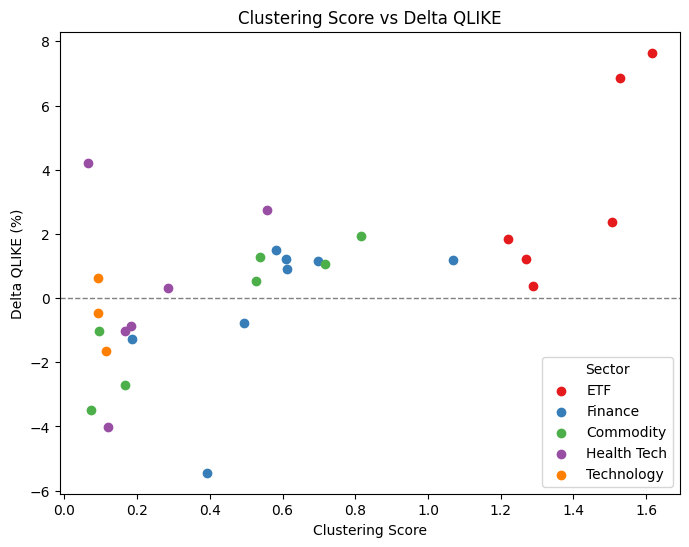

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
sectors = df_deltaQLIKE["Sector"].unique()
colors = {sector: color for sector, color in zip(sectors, plt.cm.Set1.colors)}

for sector in sectors:
    mask = df_deltaQLIKE["Sector"] == sector
    ax.scatter(
        df_deltaQLIKE[:30].loc[mask, "Clustering Score"],
        df_deltaQLIKE[:30].loc[mask, "pctQLIKE"],
        label=sector,
        color=colors[sector]
    )
ax.axhline(0, color='gray', linestyle='--', linewidth=1)  

ax.set_title('Clustering Score vs Delta QLIKE')
ax.set_xlabel('Clustering Score')
ax.set_ylabel('Delta QLIKE (%)')
ax.legend(title="Sector")
# plt.savefig("results/clustering_vs_deltaQLIKE.png", bbox_inches='tight')
plt.show()